In [1]:
import pandas as pd
import numpy as np
import pickle
from joblib import load

# Load in Expected Round Model
ER_model = load('random_forest_model.joblib')


# Load In Full Fight Data
df_basic = pd.read_pickle('basic_info.pkl')



# Load in Round by Round Data:
df_round_data = pd.read_pickle('All_Fight_Round_Data-Copy1.pkl').drop('Unnamed: 0',axis=1)
# create lowercase so they can merge
df_round_data['Fighter_lower']= df_round_data['Fighter'].str.lower()
df_basic['fighter_lower']=df_basic['fighter'].str.lower()
# same with URL
df_round_data['URL no www'] = df_round_data['URL'].str.replace('http://www.','http://',regex=False)


In [2]:
df_merged = pd.merge(df_round_data,df_basic[['date','fight_url','result','fighter','opponent','division','stance','lose_streak','fighter_lower','round','age','win_loss_ratio','win_streak','num_fights',]]
         ,left_on=['Fighter_lower','URL no www'],right_on=['fighter_lower','fight_url'],how='left').dropna().drop(['URL no www','fighter','fighter_lower'],axis=1)

In [3]:
# df_merged

In [4]:
df_merged['fight_id'] = df_merged.apply(lambda row: 
                                        (row['Fighter'] if row['result'] == 1 else row['opponent']).lower() + '_' +
                                        (row['opponent'] if row['result'] == 1 else row['Fighter']).lower() + '_' +
                                        row['date'],
                                        axis=1)

In [5]:
df_merged[['Sig. str. landed', 'Sig. str. attempted']] = df_merged['Sig. str.'].str.split(' of ', expand=True).astype(int)
df_merged[['Total str. landed', 'Total str. attempted']] = df_merged['Total str.'].str.split(' of ', expand=True).astype(int)
df_merged[['Total Head landed', 'Total Head attempted']] = df_merged['Head'].str.split(' of ', expand=True).astype(int)
df_merged[['Total Body landed', 'Total Body attempted']] = df_merged['Body'].str.split(' of ', expand=True).astype(int)
df_merged[['Total Leg landed', 'Total Leg attempted']] = df_merged['Leg'].str.split(' of ', expand=True).astype(int)
df_merged[['Total Distance landed', 'Total Distance attempted']] = df_merged['Distance'].str.split(' of ', expand=True).astype(int)
df_merged[['Total Clinch landed', 'Total Clinch attempted']] = df_merged['Clinch'].str.split(' of ', expand=True).astype(int)
df_merged[['Total Ground landed', 'Total Ground attempted']] = df_merged['Ground'].str.split(' of ', expand=True).astype(int)
df_merged[['Total Takedowns', 'Total Takedowns attempted']] = df_merged['Td %'].str.split(' of ', expand=True).astype(int)


In [6]:
df_merged.drop([
    'Fighter_lower','Sig. str.','Sig. str','Body','Leg','Distance','Clinch','Ground',
        'Total str.','Td %.1','Head','URL','Td %','result'],axis=1,inplace=True)

In [7]:
bad_ids = df_merged[(df_merged['stance']=='Sideways') | (df_merged['division']=='Super Heavyweight')]['fight_id'].unique()
df_merged = df_merged[~df_merged['fight_id'].isin(bad_ids)]



In [8]:
df_merged= pd.get_dummies(df_merged, columns=['division','stance'],drop_first=True)


one_hot_columns = [
    'division_Catch Weight', 'division_Featherweight',
    'division_Flyweight', 'division_Heavyweight', 'division_Light Heavyweight',
    'division_Lightweight', 'division_Middleweight', 'division_Welterweight',
    "division_Women's Bantamweight", "division_Women's Featherweight",
    "division_Women's Flyweight", "division_Women's Strawweight",
    'stance_Orthodox', 'stance_Southpaw', 'stance_Switch'
]

# Convert each column in the list from True/False to 1/0
for col in one_hot_columns:
    df_merged[col] = df_merged[col].astype(int)


In [9]:
pd.set_option('display.max_columns', None)
df_merged['fight_id'].unique()[:15]

array(['max holloway_arnold allen_2023-04-15',
       'edson barboza_billy quarantillo_2023-04-15',
       'azamat murzakanov_dustin jacoby_2023-04-15',
       'ion cutelaba_tanner boser_2023-04-15',
       'pedro munhoz_chris gutierrez_2023-04-15',
       'rafa garcia_clay guida_2023-04-15',
       'bill algeo_tj brown_2023-04-15',
       'brandon royval_matheus nicolau_2023-04-15',
       'zak cummings_ed herman_2023-04-15',
       'gillian robertson_piera rodriguez_2023-04-15',
       'daniel zellhuber_lando vannata_2023-04-15',
       'denise gomes_bruna brasil_2023-04-15',
       'gaston bolanos_aaron phillips_2023-04-15',
       'joselyne edwards_lucie pudilova_2023-04-15',
       'israel adesanya_alex pereira_2023-04-08'], dtype=object)

In [10]:
split_columns = df_merged['fight_id'].str.split('_', expand=True)
df_merged['Fighter1'] = split_columns[0]
df_merged['Fighter2'] = split_columns[1]

df_fighter1 = df_merged[df_merged['Fighter'].str.lower() == df_merged['Fighter1'].str.lower()].copy().drop(['Fighter1','Fighter2','round'],axis=1)
df_fighter2 = df_merged[df_merged['Fighter'].str.lower() == df_merged['Fighter2'].str.lower()].copy().drop(['Fighter1','Fighter2','round'],axis=1)


df_fighter1 = df_fighter1.add_suffix('_fighter1')
df_fighter2 = df_fighter2.add_suffix('_fighter2')

common_columns = ['Round', 'fight_id','fight_url','date']
for col in common_columns:
    df_fighter1.rename(columns={f'{col}_fighter1': col}, inplace=True)
    df_fighter2.rename(columns={f'{col}_fighter2': col}, inplace=True)

In [11]:
df_single_row_data = pd.merge(df_fighter1, df_fighter2, on=common_columns,how='inner')


df_single_row_data['Ctrl_fighter1'] = df_single_row_data['Ctrl_fighter1'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])
)

df_single_row_data['Ctrl_fighter2'] = df_single_row_data['Ctrl_fighter2'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])
)


df_single_row_data['Sig. str. %_fighter2'] = df_single_row_data['Sig. str. %_fighter2'].replace('---', 0)
df_single_row_data['Sig. str. %_fighter1'] = df_single_row_data['Sig. str. %_fighter1'].replace('---', 0)



df_single_row_data['Sig. str. %_fighter2'] = df_single_row_data['Sig. str. %_fighter2'].str.rstrip('%').astype(float) / 100
df_single_row_data['Sig. str. %_fighter1'] = df_single_row_data['Sig. str. %_fighter1'].str.rstrip('%').astype(float) / 100

df_single_row_data['Sig. str. %_fighter2'] = df_single_row_data['Sig. str. %_fighter2'].fillna(0)
df_single_row_data['Sig. str. %_fighter1'] = df_single_row_data['Sig. str. %_fighter1'].fillna(0)


# df_single_row_data

In [12]:
# df_single_row_data.columns

exclude = ['division_Catch Weight_fighter1',
 'division_Featherweight_fighter1',
 'division_Flyweight_fighter1',
 'division_Heavyweight_fighter1',
 'division_Light Heavyweight_fighter1',
 'division_Lightweight_fighter1',
 'division_Middleweight_fighter1',
 'division_Welterweight_fighter1',
 "division_Women's Bantamweight_fighter1",
 "division_Women's Featherweight_fighter1",
 "division_Women's Flyweight_fighter1",
 "division_Women's Strawweight_fighter1",
 'stance_Orthodox_fighter1',
 'stance_Southpaw_fighter1',
 'stance_Switch_fighter1','Fighter_fighter1','opponent_fighter1']

fighter1_columns = [col for col in df_single_row_data.columns if 'fighter1' in col and col not in exclude]


exclude1 = ['division_Catch Weight_fighter2',
 'division_Featherweight_fighter2',
 'division_Flyweight_fighter2',
 'division_Heavyweight_fighter2',
 'division_Light Heavyweight_fighter2',
 'division_Lightweight_fighter2',
 'division_Middleweight_fighter2',
 'division_Welterweight_fighter2',
 "division_Women's Bantamweight_fighter2",
 "division_Women's Featherweight_fighter2",
 "division_Women's Flyweight_fighter2",
 "division_Women's Strawweight_fighter2",
 'stance_Orthodox_fighter2',
 'stance_Southpaw_fighter2',
 'stance_Switch_fighter2','Fighter_fighter2','opponent_fighter2']

fighter2_columns = [col for col in df_single_row_data.columns if 'fighter2'  in col and col not in exclude1]




In [13]:
fighter2_columns


['KD_fighter2',
 'Sig. str. %_fighter2',
 'Sub. att_fighter2',
 'Rev._fighter2',
 'Ctrl_fighter2',
 'lose_streak_fighter2',
 'age_fighter2',
 'win_loss_ratio_fighter2',
 'win_streak_fighter2',
 'num_fights_fighter2',
 'Sig. str. landed_fighter2',
 'Sig. str. attempted_fighter2',
 'Total str. landed_fighter2',
 'Total str. attempted_fighter2',
 'Total Head landed_fighter2',
 'Total Head attempted_fighter2',
 'Total Body landed_fighter2',
 'Total Body attempted_fighter2',
 'Total Leg landed_fighter2',
 'Total Leg attempted_fighter2',
 'Total Distance landed_fighter2',
 'Total Distance attempted_fighter2',
 'Total Clinch landed_fighter2',
 'Total Clinch attempted_fighter2',
 'Total Ground landed_fighter2',
 'Total Ground attempted_fighter2',
 'Total Takedowns_fighter2',
 'Total Takedowns attempted_fighter2']

In [14]:

# Calculate log differential and difference
epsilon = 1e-9
for f1_col, f2_col in zip(fighter1_columns, fighter2_columns):
    base_name = f1_col.replace('_fighter1', '')
    df_single_row_data[f'log_diffential_{base_name}'] = np.log((df_single_row_data[f1_col] + epsilon) / (df_single_row_data[f2_col] + epsilon))
    df_single_row_data[f'diff_{base_name}'] = df_single_row_data[f1_col] - df_single_row_data[f2_col]

# Drop all columns related to fighter1 and fighter2
df_single_row_data.drop(columns=fighter1_columns + fighter2_columns, inplace=True)


In [15]:
# for col in df_single_row_data.columns:
#     print(col)

exclude_for_prediction = ['Fighter_fighter1','opponent_fighter1','fight_id','Fighter_fighter2','opponent_fighter2']
columns_for_prediction = [col for col in df_single_row_data.columns if col not in exclude_for_prediction]

# Use the filtered list of columns to create a new DataFrame ready for prediction
df_ready_to_predict = df_single_row_data[columns_for_prediction]


In [16]:
model_columns = [
    "Round","division_Catch Weight_fighter1","division_Featherweight_fighter1","division_Flyweight_fighter1","division_Heavyweight_fighter1",
    "division_Light Heavyweight_fighter1","division_Lightweight_fighter1","division_Middleweight_fighter1","division_Welterweight_fighter1",
    "division_Women's Bantamweight_fighter1","division_Women's Featherweight_fighter1","division_Women's Flyweight_fighter1",
    "division_Women's Strawweight_fighter1","stance_Orthodox_fighter1","stance_Southpaw_fighter1","stance_Switch_fighter1","division_Catch Weight_fighter2",
    "division_Featherweight_fighter2","division_Flyweight_fighter2","division_Heavyweight_fighter2","division_Light Heavyweight_fighter2","division_Lightweight_fighter2",
    "division_Middleweight_fighter2","division_Welterweight_fighter2","division_Women's Bantamweight_fighter2","division_Women's Featherweight_fighter2",
    "division_Women's Flyweight_fighter2","division_Women's Strawweight_fighter2","stance_Orthodox_fighter2","stance_Southpaw_fighter2",
    "stance_Switch_fighter2","log_diffential_KD","diff_KD","log_diffential_Sig. str. %","diff_Sig. str. %","log_diffential_Sub. att","diff_Sub. att",
    "log_diffential_Rev.","diff_Rev.","log_diffential_Ctrl","diff_Ctrl","log_diffential_age",
    "diff_age","log_diffential_num_fights",
    "diff_num_fights","log_diffential_Sig. str. landed","diff_Sig. str. landed","log_diffential_Sig. str. attempted","diff_Sig. str. attempted",
    "log_diffential_Total str. landed","diff_Total str. landed","log_diffential_Total str. attempted","diff_Total str. attempted",
    "log_diffential_Total Head landed","diff_Total Head landed","log_diffential_Total Head attempted","diff_Total Head attempted","log_diffential_Total Body landed",
    "diff_Total Body landed","log_diffential_Total Body attempted","diff_Total Body attempted","log_diffential_Total Leg landed","diff_Total Leg landed",
    "log_diffential_Total Leg attempted","diff_Total Leg attempted","log_diffential_Total Distance landed","diff_Total Distance landed",
    "log_diffential_Total Distance attempted","diff_Total Distance attempted","log_diffential_Total Clinch landed","diff_Total Clinch landed",
    "log_diffential_Total Clinch attempted","diff_Total Clinch attempted","log_diffential_Total Ground landed","diff_Total Ground landed",
    "log_diffential_Total Ground attempted","diff_Total Ground attempted","log_diffential_Total Takedowns","diff_Total Takedowns",
    "log_diffential_Total Takedowns attempted","diff_Total Takedowns attempted"
]
df_ready_to_predict = df_ready_to_predict[model_columns]

In [17]:
# Expected Round Probabilities
probabilities = ER_model.predict_proba(df_ready_to_predict)

In [18]:
df_ready_to_predict['prob_Fighter1'] = probabilities[:,0]
df_ready_to_predict['prob_Fighter2'] = probabilities[:,0]
df_ready_to_predict.columns

# Now combine with dataset with names:

Index(['Round', 'division_Catch Weight_fighter1',
       'division_Featherweight_fighter1', 'division_Flyweight_fighter1',
       'division_Heavyweight_fighter1', 'division_Light Heavyweight_fighter1',
       'division_Lightweight_fighter1', 'division_Middleweight_fighter1',
       'division_Welterweight_fighter1',
       'division_Women's Bantamweight_fighter1',
       'division_Women's Featherweight_fighter1',
       'division_Women's Flyweight_fighter1',
       'division_Women's Strawweight_fighter1', 'stance_Orthodox_fighter1',
       'stance_Southpaw_fighter1', 'stance_Switch_fighter1',
       'division_Catch Weight_fighter2', 'division_Featherweight_fighter2',
       'division_Flyweight_fighter2', 'division_Heavyweight_fighter2',
       'division_Light Heavyweight_fighter2', 'division_Lightweight_fighter2',
       'division_Middleweight_fighter2', 'division_Welterweight_fighter2',
       'division_Women's Bantamweight_fighter2',
       'division_Women's Featherweight_fighter2',
 

In [19]:
# for col in df_single_row_data.columns:
#     print(col)

# exclude_for_prediction = ['Fighter_fighter1','opponent_fighter1','fight_id','Fighter_fighter2','opponent_fighter2']
# columns_for_prediction = [col for col in df_single_row_data.columns if col not in exclude_for_prediction]

# Use the filtered list of columns to create a new DataFrame ready for prediction
df_predicted_round_data = df_single_row_data[['date','Fighter_fighter1','Fighter_fighter2', 'Round','fight_id','fight_url']].copy()
df_predicted_round_data['prob_Fighter1'] = probabilities[:,0]
df_predicted_round_data['prob_Fighter2'] = probabilities[:,1]

df_predicted_round_data

,date,Fighter_fighter1,Fighter_fighter2,Round,fight_id,fight_url,prob_Fighter1,prob_Fighter2
0,2023-04-15,Max Holloway,Arnold Allen,1,max holloway_arnold allen_2023-04-15,http://ufcstats.com/fight-details/6049301b4dee...,1.000,0.000
1,2023-04-15,Max Holloway,Arnold Allen,2,max holloway_arnold allen_2023-04-15,http://ufcstats.com/fight-details/6049301b4dee...,0.908,0.092
2,2023-04-15,Max Holloway,Arnold Allen,3,max holloway_arnold allen_2023-04-15,http://ufcstats.com/fight-details/6049301b4dee...,0.992,0.008
3,2023-04-15,Max Holloway,Arnold Allen,4,max holloway_arnold allen_2023-04-15,http://ufcstats.com/fight-details/6049301b4dee...,0.992,0.008
4,2023-04-15,Max Holloway,Arnold Allen,5,max holloway_arnold allen_2023-04-15,http://ufcstats.com/fight-details/6049301b4dee...,0.258,0.742
...,...,...,...,...,...,...,...,...
20170,2000-04-14,Ikuhisa Minowa,Joe Slick,2,ikuhisa minowa_joe slick_2000-04-14,http://ufcstats.com/fight-details/9397493152c0...,0.634,0.366
20171,2000-04-14,Ikuhisa Minowa,Joe Slick,3,ikuhisa minowa_joe slick_2000-04-14,http://ufcstats.com/fight-details/9397493152c0...,0.234,0.766
20172,2000-04-14,Laverne Clark,Koji Oishi,1,laverne clark_koji oishi_2000-04-14,http://ufcstats.com/fight-details/cf8fe599f0b4...,0.776,0.224
20173,2000-04-14,Laverne Clark,Koji Oishi,2,laverne clark_koji oishi_2000-04-14,http://ufcstats.com/fight-details/cf8fe599f0b4...,0.400,0.600


In [20]:

# df_basic['fight_id']df_basic['date'].astype('str')
excluded_from_basic = ['event_url','dob','time','fighter_url','opponent_url','referee','fighter_lower']

df_basic_relevant = df_basic.loc[:, ~df_basic.columns.isin(excluded_from_basic)]
# df_basic_relevant = df_basic_relevant.sort_values(by=['date'])
# df_basic_relevant

In [21]:
df_l2_model = df_basic_relevant[['date','fighter','opponent','result','fight_url','age','stance','division','reach','height','days_since_last_comp','num_fights']].reset_index(drop=True)

In [22]:
# Group by fighter, then apply a lambda function to calculate win % for the first 5 fights
global_first5_win_percentages = df_basic_relevant.groupby('fighter').apply(lambda x: x.head(3)['result'].mean()).mean()


# 1 0.43081494057724956
# 2 0.4897488467452588
# 3 0.5554126473740622
# 4 0.577426810477658
# 5 0.6042471042471043


def last_5_wins_losses_ratio(row, df):
    # Filter the DataFrame for matches where the fighter name matches and occurred before the current row
    past_matches = df[(df['fighter'] == row['fighter']) & (df.index < row.name)]
    # Get the last 5 matches or fewer if not available


    last_5 = past_matches.tail(5)
    # Calculate the sum of results (wins) in the last 5 matches
    wins = last_5['result'].sum()
    if len(last_5) > 0:
        win_loss_ratio = wins/len(last_5)
    else:
        win_loss_ratio = 0
    if(len(past_matches) < 1):
        #Impute average for a fighter's first five fights
        return 0.43081494057724956
    elif(len(past_matches)==1):
        return (0.75*win_loss_ratio+0.25*0.48974)
    elif(len(past_matches)==2):
        return (0.75*win_loss_ratio+0.25*0.555412)
    elif(len(past_matches)==3):
        return (0.75*win_loss_ratio+0.25*0.57742)
    elif(len(past_matches)==4):
        return (0.75*win_loss_ratio+0.25*0.604)
    

    

    return win_loss_ratio



# Ensure the DataFrame has an appropriate index to use .iloc and row.name


# Apply the function to each row
df_l2_model['last_5_win_ratio'] = df_l2_model.apply(lambda row: last_5_wins_losses_ratio(row, df_basic_relevant), axis=1)


In [23]:

global_average_ER_fighter1 = df_predicted_round_data.groupby('Fighter_fighter1').apply(lambda x: x.head(5)['prob_Fighter1']).mean()
global_average_ER_fighter2 = df_predicted_round_data.groupby('Fighter_fighter2').apply(lambda x: x.head(5)['prob_Fighter2']).mean()

global_average_ER = (global_average_ER_fighter1+global_average_ER_fighter2)/2
global_average_ER

0.48425633476244606

In [24]:
df_l2_model.sort_values('date', ascending=True, inplace=True)
df_predicted_round_data.sort_values('date', ascending=True, inplace=True)
df_predicted_round_data['Fighter_fighter1'] = df_predicted_round_data['Fighter_fighter1'].str.strip().str.lower()
df_predicted_round_data['Fighter_fighter2'] = df_predicted_round_data['Fighter_fighter2'].str.strip().str.lower()


global_average_ER_fighter1 = df_predicted_round_data.groupby('Fighter_fighter1').apply(lambda x: x.head(5)['prob_Fighter1']).mean()
global_average_ER_fighter2 = df_predicted_round_data.groupby('Fighter_fighter2').apply(lambda x: x.head(5)['prob_Fighter2']).mean()

global_average_ER = (global_average_ER_fighter1+global_average_ER_fighter2)/2


def calculate_L15_ER_average(row, df_other):
    # Filter df_other for matches involving the fighter and before the current date
    matches = df_other[(df_other['date'] < row['date']) & 
                       ((df_other['Fighter_fighter1'] == row['fighter']) | 
                        (df_other['Fighter_fighter2'] == row['fighter']))]
    
    # Get the last 10 matches
    last_10_matches = matches.tail(15)
    
    # Calculate the mean of the probabilities for these matches
    prob_values = []
    for _, match_row in last_10_matches.iterrows():
        if match_row['Fighter_fighter1'] == row['fighter']:
            prob_values.append(match_row['prob_Fighter1'])
        else:
            prob_values.append(match_row['prob_Fighter2'])
    
    # Calcculate the mean, if there are no prob values (no matches found), set it to NaN or some default value
    return np.mean(prob_values) if prob_values else global_average_ER

df_l2_model['L15_ER_average'] = df_l2_model.apply(lambda row: calculate_L15_ER_average(row, df_predicted_round_data), axis=1)


In [25]:
# def get_last_5_ER_values(row, df_other):
#     # Filter df_other for matches involving the fighter and before the current date
#     matches = df_other[(df_other['date'] < row['date']) &
#                        ((df_other['Fighter_fighter1'] == row['fighter'].strip().lower()) |
#                         (df_other['Fighter_fighter2'] == row['fighter'].strip().lower()))]
    
#     # Sort matches in ascending order to get the last 5 matches at the end
#     matches_sorted = matches.sort_values('date', ascending=True)
    
#     # Get the last 5 matches
#     last_5_matches = matches_sorted.tail(5)
    
#     # Extract the ER values for these matches
#     ER_values = []
#     for _, match_row in last_5_matches.iterrows():
#         if match_row['Fighter_fighter1'] == row['fighter'].strip().lower():
#             ER_values.append(match_row['prob_Fighter1'])
#         else:
#             ER_values.append(match_row['prob_Fighter2'])
    
#     # If there are less than 5 matches, fill the remaining values with NaN or global_average_ER
#     ER_values += [np.nan] * (5 - len(ER_values))
    
#     return pd.Series(ER_values, index=[f'ER_last_round_{i+1}' for i in range(5)])

# new_columns = df_l2_model.apply(lambda row: get_last_5_ER_values(row, df_predicted_round_data), axis=1)
# df_l2_model = pd.concat([df_l2_model, new_columns], axis=1)



In [26]:
global_first_fight_elo = df_basic_relevant.groupby('fighter').apply(lambda x: x.head(1)['elo']).mean()
global_first_fight_trueskill = df_basic_relevant.groupby('fighter').apply(lambda x: x.head(1)['trueskill']).mean()


def find_prev_elo_trueskill(row, df_lookup):
    # Filter for fights involving the fighter and before the current date
    past_fights = df_lookup[(df_lookup['date'] < row['date']) & 
                            ((df_lookup['fighter'] == row['fighter']))]
    
    # Get the most recent fight
    last_fight = past_fights.tail(1)
    
    # Return the Elo score from the most recent fight, if any
    if not last_fight.empty:
        return last_fight['elo'].iloc[0], last_fight['trueskill'].iloc[0]  # Assuming these columns exist
    else:
        return global_first_fight_elo, global_first_fight_trueskill  # Return NaN for both if there's no previous fight

# Update the DataFrame to store the returned tuple in two new columns
df_l2_model[['prev_elo', 'prev_trueskill']] = df_l2_model.apply(lambda row: find_prev_elo_trueskill(row, df_basic_relevant), axis=1, result_type='expand')

In [27]:
def find_win_lose_streak(row, df_lookup):
    # Filter for fights involving the fighter and before the current date
    past_fights = df_lookup[(df_lookup['date'] < row['date']) & 
                            (df_lookup['fighter'] == row['fighter'])]
    
    # Get the most recent fight
    last_fight = past_fights.sort_values(by='date', ascending=False).head(1)
    
    # Return the win and lose streak from the most recent fight, if any
    if not last_fight.empty:
        if last_fight['win_streak'].iloc[0] >= last_fight['lose_streak'].iloc[0]:
            return last_fight['win_streak'].iloc[0]
        else:
            return -last_fight['lose_streak'].iloc[0]
    else:
        return 0
# Assuming 'fighter' column exists in df_l2_model and refers to the fighter's name
# And assuming df_basic_relevant contains a column 'elo' with the Elo score

# results = df_l2_model.apply(lambda row: find_win_lose_streak(row, df_basic_relevant), axis=1)

# Splitting the results into two separate columns
df_l2_model['win/lose_streak'] = df_l2_model.apply(lambda row: find_win_lose_streak(row, df_basic_relevant), axis=1)


In [28]:
# find global average of finish percentage of fighters with 3 or less fights:
df_filtered = df_basic_relevant.groupby('fighter').head(3)
finishes = df_filtered[df_filtered['result'] == 1 & df_filtered['method'].isin(['SUB', 'KO/TKO'])]
total_fights = len(df_filtered)
global_average = (len(finishes)/total_fights)

def find_finish_percentage(row, df_lookup):
    past_fights = df_lookup[(df_lookup['date'] < row['date']) & 
                            (df_lookup['fighter'] == row['fighter'])]
    
    finishes = past_fights[past_fights['result'] == 1 & past_fights['method'].isin(['SUB', 'KO/TKO'])]
    total_fights = len(past_fights)

    if total_fights > 0:
        finish_percentage = (len(finishes) / total_fights)
    else:
        finish_percentage = global_average # global average of fighter's first 3 fights
    
    return finish_percentage


    
df_l2_model['finish_pcnt'] = df_l2_model.apply(lambda row: find_finish_percentage(row, df_basic_relevant), axis=1)

    

In [29]:
def total_win_loss(row, df):
     # Filter the DataFrame for matches where the fighter name matches and occurred before the current row
    past_matches = df[(df['fighter'] == row['fighter']) & (df.index < row.name)]
   
    
    if len(past_matches) > 0:
        wins = past_matches['result'].sum()
        # Number of fights is the total number of matches in last 5 or the actual count if less than 5
        num_fights = len(past_matches)
        # Losses are the number of fights minus the wins
        losses = num_fights - wins
        # return pd.Series([wins, losses])
        return wins/num_fights
    else: 
        return 0


# df_l2_model[['total_wins', 'total_losses']] = df_l2_model.apply(lambda row: total_win_loss(row, df_basic_relevant), axis=1)
df_l2_model['total_win/loss_ratio'] = df_l2_model.apply(lambda row: total_win_loss(row, df_basic_relevant), axis=1)



In [30]:
def get_days_since_started(row, df_lookup):
    # Filter to get past fights for the current fighter
    past_fights = df_lookup[(df_lookup['date'] < row['date']) & 
                            (df_lookup['fighter'] == row['fighter'])]
    
    # If there are past fights, calculate days since the first fight
    if not past_fights.empty:
        # Sort past_fights by date to find the first fight
        past_fights_sorted = past_fights.sort_values(by='date', ascending=True)
        past_fights_sorted['date'] = pd.to_datetime(past_fights_sorted['date'])
        first_fight_date = past_fights_sorted.iloc[0]['date']
        current_fight_date = pd.to_datetime(row['date'])
        
        # Calculate the difference in age (days) from the first fight to the current fight
        days_since_started = (current_fight_date - first_fight_date).days
    else:
        # If no past fights are found, this is the fighter's first fight
        days_since_started = 0

    return days_since_started

# Apply the function
df_l2_model['days_since_started'] = df_l2_model.apply(lambda row: get_days_since_started(row, df_basic_relevant), axis=1)


In [31]:
#  # Calculate total significant strikes and total competition time for all fights
# total_sig_strikes = df_basic_relevant['sig_strikes_landed'].sum()
# total_comp_time = df_basic_relevant['total_comp_time'].sum()  # Assuming this is in seconds

# # Calculate and return the global average of significant strikes per minute
# gloabl_average_sig_strikes_per_min = (total_sig_strikes / total_comp_time) * 60

df_first_fights = df_basic_relevant[['fighter','sig_strikes_landed','total_comp_time']].dropna().drop_duplicates(subset='fighter', keep='first')
total_sig_strikes_first_fights = df_first_fights['sig_strikes_landed'].sum()
total_comp_time_first_fights = df_basic_relevant['total_comp_time'].sum()  # Assuming this is in seconds
global_average_sig_strikes_per_min_first_fights = (total_sig_strikes_first_fights / total_comp_time_first_fights) * 60

print(global_average_sig_strikes_per_min_first_fights)

def get_sig_strikes_per_minute(row, df_lookup):
    # Filter to get past fights for the current fighter
    past_fights = df_lookup[(df_lookup['date'] < row['date']) & 
                            (df_lookup['fighter'] == row['fighter'])]
    
    if not past_fights.empty:
        # Sum up significant strikes and total competition time for past fights
        total_sig_strikes = past_fights['sig_strikes_landed'].sum()
        total_comp_time = past_fights['total_comp_time'].sum()  # Assuming this is in seconds
        
        # Calculate significant strikes per minute for past fights
        sig_strikes_per_minute = (total_sig_strikes / total_comp_time) * 60
    else:
        # If no past fights, use the global average
        sig_strikes_per_minute = global_average_sig_strikes_per_min_first_fights

    return sig_strikes_per_minute




# Example of applying the function (assuming df is your DataFrame)
df_l2_model['sig_strikes_per_minute'] = df_l2_model.apply(lambda row: get_sig_strikes_per_minute(row, df_basic_relevant), axis=1)


0.07059141073468737


In [32]:
# df_l2_model = df_l2_model[df_l2_model['date'] > '2005-01-01'].sort_values('date')

In [33]:

df_l2_model = df_l2_model.sort_values(by=['fight_url','fighter'])
df_l2_model['appearence_order'] = df_l2_model.groupby('fight_url').cumcount()+1
df_l2_model

#Turn into fighter1 and fighter2
df_fighter1_l2 = df_l2_model[df_l2_model['appearence_order'] == 1].copy()
df_fighter2_l2 = df_l2_model[df_l2_model['appearence_order'] == 2].copy()


df_fighter1_l2 = df_fighter1_l2.add_suffix('_fighter1')
df_fighter2_l2 = df_fighter2_l2.add_suffix('_fighter2')

common_columns = ['date','fight_url','appearence_order','division']
for col in common_columns:
    df_fighter1_l2.rename(columns={f'{col}_fighter1': col}, inplace=True)
    df_fighter2_l2.rename(columns={f'{col}_fighter2': col}, inplace=True)


df_single_row_l2 = pd.merge(df_fighter1_l2,df_fighter2_l2,on=['date','fight_url','division'])



In [34]:
#Fix null values for age by using average age based on number of fights
average_age_by_num_fights = df_basic_relevant.groupby('num_fights')['age'].mean()
for index, row in df_single_row_l2.iterrows():
    # For fighter 1
    if pd.isnull(row['age_fighter1']):
        num_fights = row['num_fights_fighter1']
        # Compute average age for all fighters in their num_fights-th fight
        if num_fights in average_age_by_num_fights:
            df_single_row_l2.at[index, 'age_fighter1'] = average_age_by_num_fights[num_fights]
        # Assign back to df_single_row_l2
        
    # For fighter 2
    if pd.isnull(row['age_fighter2']):
        num_fights = row['num_fights_fighter2']
        # Compute average age for all fighters in their num_fights-th fight
        if num_fights in average_age_by_num_fights:
            df_single_row_l2.at[index, 'age_fighter2'] = average_age_by_num_fights[num_fights]
        # Assign back to df_single_row_l2
            


    
    # Now fixing null reaches:
    if pd.isnull(row['reach_fighter1']):
        df_single_row_l2.at[index, 'reach_fighter1'] = row['height_fighter1']

    if pd.isnull(row['reach_fighter2']):
        df_single_row_l2.at[index, 'reach_fighter2'] = row['height_fighter2']

# df_single_row_l2['reach_differential'] = df_single_row_l2['reach_fighter1'] - df_single_row_l2['reach_fighter2']


In [35]:
# df_single_row_l2.isnull().sum()
# df_single_row_l2[['reach_fighter1','height_fighter1']]




In [36]:
df_single_row_l2  = df_single_row_l2.sort_values('date')
df_single_row_l2_model = df_single_row_l2.drop(['opponent_fighter1',
                                          'result_fighter2','opponent_fighter2','appearence_order_x',
                                          'appearence_order_y','fight_url', 'fighter_fighter1','fighter_fighter2','date','stance_fighter1','stance_fighter2'
                                          ],axis=1).dropna()
df_single_row_l2_model = pd.get_dummies(df_single_row_l2_model,columns=['division'],drop_first=True,dtype=int)

In [37]:
# # df_single_row_l2_model['age_differential'] = df_single_row_l2_model['age_fighter1']/df_single_row_l2_model['age_fighter2']
# # df_single_row_l2_model.drop(columns=['age_fighter1','age_fighter2'],axis=1,inplace=True)

# df_single_row_l2_model
# df_single_row_l2[df_single_row_l2['date']>'2000-01-01']

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df_single_row_l2_model.drop('result_fighter1', axis=1)
y = df_single_row_l2_model['result_fighter1']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
split_idx = int(len(X)*.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]





In [39]:
# X_train.to_csv('X_train.csv')
# y_train.to_csv('y_train.csv')
# X_test.to_csv('X_test.csv')
# y_test.to_csv('y_test.csv')

In [40]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=27)

rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=27)

In [41]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.5917788802267895
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       726
           1       0.59      0.55      0.57       685

    accuracy                           0.59      1411
   macro avg       0.59      0.59      0.59      1411
weighted avg       0.59      0.59      0.59      1411



In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [43]:
rf_predicted_probabilities = rf_model.predict_proba(X_test)
probabilities_df = pd.DataFrame(rf_predicted_probabilities, columns=['opponent_prob', 'fighter1_prob'])
probabilities_df.index = X_test.index
df_with_probs = df_single_row_l2.join(probabilities_df,how="left")

In [44]:
df_with_probs[['date','fighter_fighter1','opponent_fighter1','result_fighter1','fight_url','fighter1_prob','opponent_prob']].dropna().sort_values('date').to_csv('RF_prediction_values.csv')
# len(rf_predicted_probabilities)
# df_with_probs

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ANNmodel = MLPClassifier(hidden_layer_sizes=(100,100,30,30,20,10), max_iter=500, activation='relu', solver='adam', random_state=27)
ANNmodel.fit(X_train_scaled, y_train)


MLPClassifier(hidden_layer_sizes=(100, 100, 30, 30, 20, 10), max_iter=500,
              random_state=27)

In [46]:
# Making predictions
y_pred_ANN = ANNmodel.predict(X_test_scaled)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5917788802267895

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.61       726
           1       0.59      0.55      0.57       685

    accuracy                           0.59      1411
   macro avg       0.59      0.59      0.59      1411
weighted avg       0.59      0.59      0.59      1411



In [47]:
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Use the DataFrame column names directly
feature_names = X.columns

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. age_fighter2 (0.06419757155989807)
2. age_fighter1 (0.06367519497283686)
3. prev_elo_fighter1 (0.04462215811272538)
4. L15_ER_average_fighter1 (0.044209797593842574)
5. prev_elo_fighter2 (0.04372463523601167)
6. L15_ER_average_fighter2 (0.042031331330460095)
7. sig_strikes_per_minute_fighter2 (0.040387033493505954)
8. reach_fighter2 (0.04022296508504452)
9. prev_trueskill_fighter2 (0.04008825836519559)
10. prev_trueskill_fighter1 (0.03995272164974393)
11. reach_fighter1 (0.03874901016119891)
12. days_since_last_comp_fighter1 (0.03865679646253951)
13. days_since_started_fighter2 (0.03831100220819921)
14. sig_strikes_per_minute_fighter1 (0.038131638306012745)
15. days_since_last_comp_fighter2 (0.037782817905868446)
16. days_since_started_fighter1 (0.036909905204463786)
17. height_fighter2 (0.034095455943592264)
18. height_fighter1 (0.033687984006335894)
19. finish_pcnt_fighter2 (0.02447445968864226)
20. finish_pcnt_fighter1 (0.02382574033336429)
21. num_fights_fighter

In [48]:
# df_basic_relevant

Standardize data with "normal distribution" 0 is average
Fix all the features with null values like that 


Get betting data and find out if the favorite wins more than 62% of the time 

Query RF model to see feature importance 


Add in Significant Strikes / min (L5)

Look at trend of fighter's win% over time

add days since last fight, add days since started

backgorund research into benchmarking 


1 0.43081494057724956
2 0.4897488467452588
3 0.5554126473740622
4 0.577426810477658
5 0.6042471042471043
6 0.6024096385542169
7 0.611391223155929
8 0.630859375
9 0.6315896188158961
10 0.634736842105263
11 0.6347766946270688
12 0.6340057636887608
13 0.6373626373626373
14 0.6428571428571428
15 0.6431007751937984
16 0.6463150289017341
17 0.6463189049204587
18 0.6391009329940628
19 0.6374269005847956
20 0.6355555555555555
21 0.6355555555555553
22 0.6325757575757576
23 0.6304347826086956
24 0.6159420289855071
25 0.6242105263157897
26 0.6083916083916083
27 0.613960113960114
28 0.6339285714285714
29 0.6206896551724139
30 0.6166666666666666
31 0.6129032258064516
32 0.59765625
33 0.5930735930735931
34 0.5588235294117647
35 0.5857142857142857
36 0.601851851851852
37 0.5945945945945946
38 0.5964912280701754
39 0.5897435897435898
40 0.6


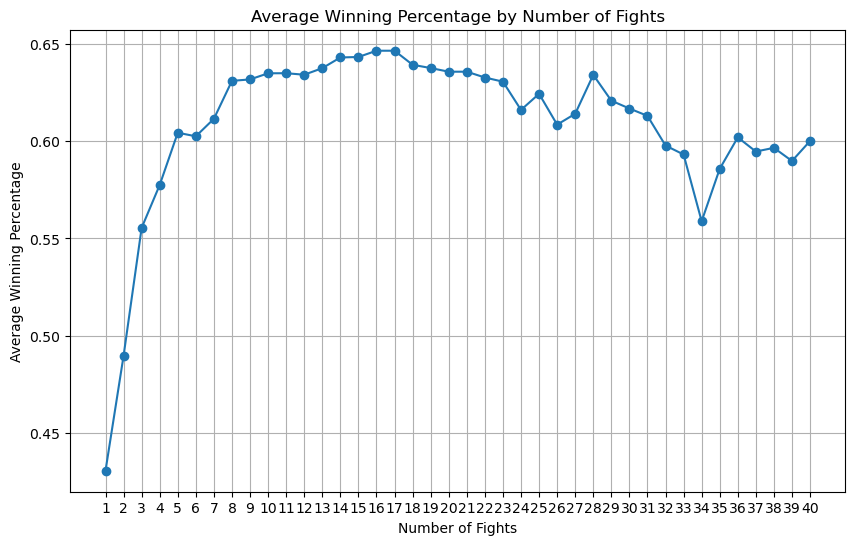

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and it contains columns 'fighter' and 'won' (1 for win, 0 for loss)

# Step 2: Calculating Win Rates
# Initialize a dictionary to store average win rates for each fight count
average_win_rates = {}

# Loop through each fight count from 1 to 30
for fight_count in range(1, 41):
    # Filter fighters who have at least 'fight_count' fights
    eligible_fighters = df_basic_relevant['fighter'].value_counts()[df_basic_relevant['fighter'].value_counts() >= fight_count].index
    filtered_df = df_basic_relevant[df_basic_relevant['fighter'].isin(eligible_fighters)]
    
    
    # Calculate cumulative win rate for each fighter up to 'fight_count' fights
    win_rates = filtered_df.groupby('fighter').head(fight_count).groupby('fighter')['result'].mean()
    
    # Calculate the average win rate across all eligible fighters
    average_win_rate = win_rates.mean()
    print(fight_count, average_win_rate)
    average_win_rates[fight_count] = average_win_rate

# Convert the dictionary to a Series for easy plotting
win_rate_series = pd.Series(average_win_rates)

# Step 3: Plotting the Results
plt.figure(figsize=(10, 6))
win_rate_series.plot(kind='line', marker='o')
plt.title('Average Winning Percentage by Number of Fights')
plt.xlabel('Number of Fights')
plt.ylabel('Average Winning Percentage')
plt.xticks(np.arange(1, 41, 1))
plt.grid(True)
plt.show()


In [50]:
df = df_single_row_l2_model.copy()

df['fighter1_older'] = df['age_fighter1'] > df['age_fighter2']

df['older_fighter_won'] = ((df['fighter1_older'] == True) & (df['result_fighter1'] == 1)) | \
                          ((df['fighter1_older'] == False) & (df['result_fighter1'] == 0))


older_fighter_win_count = df['older_fighter_won'].sum()
total_fights = len(df)
older_fighter_win_ratio = older_fighter_win_count / total_fights

print(f"Older fighter win ratio: {older_fighter_win_ratio:.2f} or {older_fighter_win_ratio*100:.2f}%")


Older fighter win ratio: 0.44 or 44.04%


/var/folders/v5/23qsn2tj1pg_yz86qk9f46b40000gp/T/ipykernel_3165/4240750904.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic_relevant['age_years'] = df_basic_relevant['age'] / 365.25
/var/folders/v5/23qsn2tj1pg_yz86qk9f46b40000gp/T/ipykernel_3165/4240750904.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic_relevant['age_bin'] = pd.cut(df_basic_relevant['age_years'], bins=age_bins, labels=age_bins[:-1])
/var/folders/v5/23qsn2tj1pg_yz86qk9f46b40000gp/T/ipykernel_3165/4240750904.py:14: F

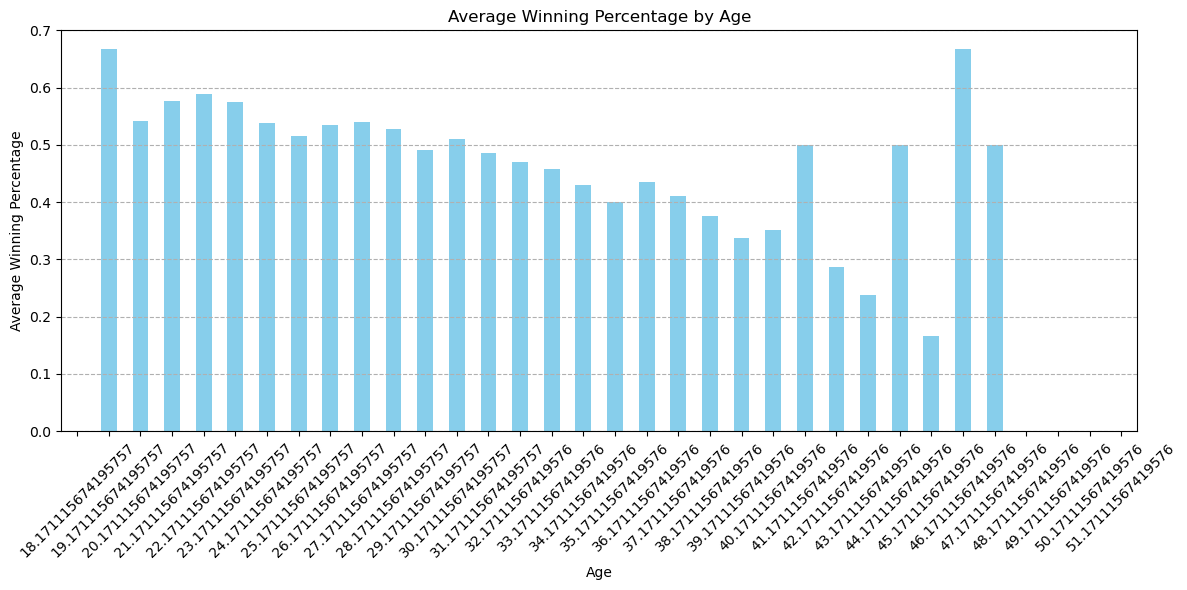

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame with 'age' in days
# Convert 'age' from days to years
df_basic_relevant['age_years'] = df_basic_relevant['age'] / 365.25

# Bin ages by year
age_bins = np.arange(df_basic_relevant['age_years'].min(), df_basic_relevant['age_years'].max() + 1)
df_basic_relevant['age_bin'] = pd.cut(df_basic_relevant['age_years'], bins=age_bins, labels=age_bins[:-1])

# Calculate winning percentages for each age bin
win_rates_by_age_bin = df_basic_relevant.groupby('age_bin')['result'].mean()

# Plotting the results
plt.figure(figsize=(12, 6))
win_rates_by_age_bin.plot(kind='bar', color='skyblue')
plt.title('Average Winning Percentage by Age')
plt.xlabel('Age')
plt.ylabel('Average Winning Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


/var/folders/v5/23qsn2tj1pg_yz86qk9f46b40000gp/T/ipykernel_3165/2009794684.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic_relevant['age_years'] = df_basic_relevant['age'] / 365.25
/var/folders/v5/23qsn2tj1pg_yz86qk9f46b40000gp/T/ipykernel_3165/2009794684.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic_relevant['age_bin'] = pd.cut(df_basic_relevant['age_years'], bins=age_bins, labels=age_bins[:-1])
/var/folders/v5/23qsn2tj1pg_yz86qk9f46b40000gp/T/ipykernel_3165/2009794684.py:14: F

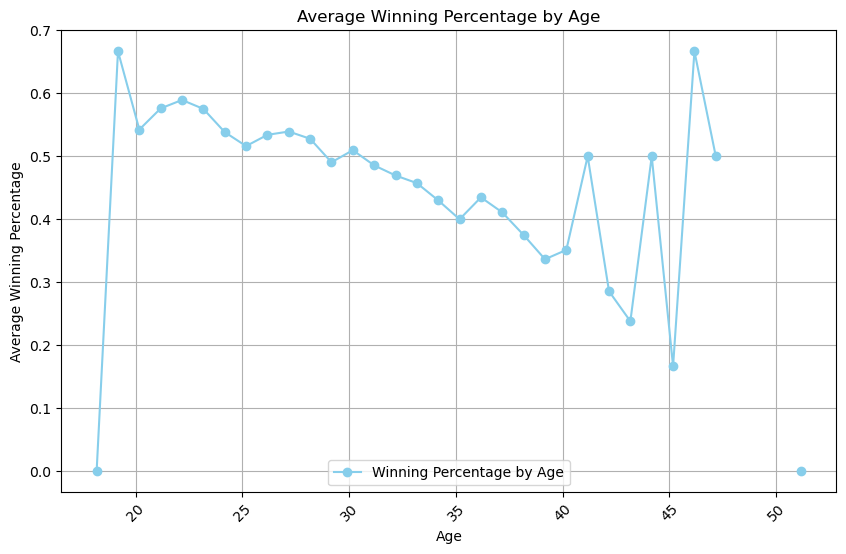

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_basic_relevant is your DataFrame with 'age' in days
# Convert 'age' from days to years
df_basic_relevant['age_years'] = df_basic_relevant['age'] / 365.25

# Bin ages by year
age_bins = np.arange(df_basic_relevant['age_years'].min(), df_basic_relevant['age_years'].max() + 1)
df_basic_relevant['age_bin'] = pd.cut(df_basic_relevant['age_years'], bins=age_bins, labels=age_bins[:-1])

# Calculate winning percentages for each age bin
win_rates_by_age_bin = df_basic_relevant.groupby('age_bin')['result'].mean()

# Prepare data for plotting
x = [float(age) for age in age_bins[:-1]]  # Age bins as integers (or floats) for x-axis
y = win_rates_by_age_bin.values  # Corresponding win rates

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='skyblue', label='Winning Percentage by Age')  # Line + marker plot
plt.title('Average Winning Percentage by Age')
plt.xlabel('Age')
plt.ylabel('Average Winning Percentage')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()
plt.show()


In [53]:
df_basic_relevant
df_single_row_l2_model

,result_fighter1,age_fighter1,reach_fighter1,height_fighter1,days_since_last_comp_fighter1,num_fights_fighter1,last_5_win_ratio_fighter1,L15_ER_average_fighter1,prev_elo_fighter1,prev_trueskill_fighter1,win/lose_streak_fighter1,finish_pcnt_fighter1,total_win/loss_ratio_fighter1,days_since_started_fighter1,sig_strikes_per_minute_fighter1,age_fighter2,reach_fighter2,height_fighter2,days_since_last_comp_fighter2,num_fights_fighter2,last_5_win_ratio_fighter2,L15_ER_average_fighter2,prev_elo_fighter2,prev_trueskill_fighter2,win/lose_streak_fighter2,finish_pcnt_fighter2,total_win/loss_ratio_fighter2,days_since_started_fighter2,sig_strikes_per_minute_fighter2,division_Catch Weight,division_Featherweight,division_Flyweight,division_Heavyweight,division_Light Heavyweight,division_Lightweight,division_Middleweight,division_Open Weight,division_Super Heavyweight,division_Welterweight,division_Women's Bantamweight,division_Women's Featherweight,division_Women's Flyweight,division_Women's Strawweight
705,0,10271.758574,68.0,68.0,216.108044,1.0,0.430815,0.499974,1195.203570,24.821247,0,0.506824,0.000000,0,0.070591,10271.758574,75.0,75.0,216.108044,1.0,0.430815,0.499974,1195.203570,24.821247,0,0.506824,0.000000,0,0.070591,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4005,1,11153.000000,74.0,74.0,0.000000,2.0,0.872435,0.499974,1195.203570,24.821247,0,0.506824,1.000000,0,0.070591,10436.635029,70.0,70.0,0.000000,2.0,0.872435,0.499974,1195.203570,24.821247,0,0.506824,1.000000,0,0.070591,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4748,0,10594.565217,75.0,75.0,0.000000,3.0,0.888853,0.499974,1195.203570,24.821247,0,0.506824,1.000000,0,0.070591,9951.000000,73.0,73.0,0.000000,3.0,0.888853,0.499974,1195.203570,24.821247,0,0.506824,1.000000,0,0.070591,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4030,0,10594.565217,72.0,72.0,0.000000,3.0,0.888853,0.499974,1195.203570,24.821247,0,0.506824,1.000000,0,0.070591,11153.000000,74.0,74.0,0.000000,3.0,0.888853,0.499974,1195.203570,24.821247,0,0.506824,1.000000,0,0.070591,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2153,1,10271.758574,70.0,70.0,216.108044,1.0,0.430815,0.499974,1195.203570,24.821247,0,0.506824,0.000000,0,0.070591,6672.000000,72.0,72.0,216.108044,1.0,0.430815,0.499974,1195.203570,24.821247,0,0.506824,0.000000,0,0.070591,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4872,1,12363.000000,73.0,72.0,210.000000,7.0,0.600000,0.604267,1244.731396,27.719255,-1,0.666667,0.500000,959,1.349330,12016.000000,72.0,69.0,126.000000,7.0,0.600000,0.559600,1183.531344,24.417536,1,0.500000,0.500000,1141,1.020025,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5207,1,11199.000000,68.0,69.0,343.000000,7.0,0.600000,0.455273,1294.003839,31.894817,2,0.500000,0.666667,1050,0.945350,11056.000000,66.0,66.0,133.000000,9.0,0.800000,0.642533,1371.909497,35.350551,4,0.250000,0.875000,2716,0.794102,0,0,1,0,0,0,0,0,0,0,0,0,0,0
519,0,12306.000000,71.0,69.0,1004.000000,4.0,0.144355,0.146250,1047.937462,15.537690,-3,0.666667,0.000000,3248,0.751667,11170.000000,69.0,67.0,216.108044,1.0,0.430815,0.499974,1195.203570,24.821247,0,0.506824,0.000000,0,0.070591,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2689,0,10812.000000,65.0,66.0,216.108044,1.0,0.430815,0.499974,1195.203570,24.821247,0,0.506824,0.000000,0,0.070591,8507.000000,63.0,62.0,210.000000,2.0,0.122435,0.114000,1157.100291,19.555044,-1,1.000000,0.000000,210,1.266667,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [54]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.metrics import accuracy_score

# # Initialize the classifier
# classifier = RandomForestClassifier(n_estimators=100, random_state=27)

# # Initialize Sequential Feature Selector
# sfs = SequentialFeatureSelector(classifier, n_features_to_select="auto", direction='forward', scoring='accuracy', cv=5)

# # Fit SFS on the training data
# sfs.fit(X_train, y_train)

# # Transform training and test data to select the best features
# X_train_sfs = sfs.transform(X_train)
# X_test_sfs = sfs.transform(X_test)

# # Train the classifier on the reduced dataset
# classifier.fit(X_train_sfs, y_train)

# # Make predictions and evaluate the model
# y_pred = classifier.predict(X_test_sfs)
# accuracy = accuracy_score(y_test, y_pred)

# print("Selected features:", sfs.get_support(indices=True))
# print("Model accuracy with selected features:", accuracy)




In [55]:
df_basic_relevant['sig_strikes_per_minute'] = df_basic_relevant['sig_strikes_landed']/(df_basic_relevant['total_comp_time']/60)

df_basic_relevant

/var/folders/v5/23qsn2tj1pg_yz86qk9f46b40000gp/T/ipykernel_3165/1868114284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic_relevant['sig_strikes_per_minute'] = df_basic_relevant['sig_strikes_landed']/(df_basic_relevant['total_comp_time']/60)


,date,fight_url,result,fighter,opponent,division,stance,method,total_comp_time,round,time_format,reach,height,age,knockdowns,sub_attempts,reversals,control,takedowns_landed,takedowns_attempts,sig_strikes_landed,sig_strikes_attempts,total_strikes_landed,total_strikes_attempts,head_strikes_landed,head_strikes_attempts,body_strikes_landed,body_strikes_attempts,leg_strikes_landed,leg_strikes_attempts,distance_strikes_landed,distance_strikes_attempts,clinch_strikes_landed,clinch_strikes_attempts,ground_strikes_landed,ground_strikes_attempts,KO_losses,days_since_last_comp,lose_streak,win_streak,win_loss_ratio,stamina,num_fights,trueskill,elo,age_years,age_bin,sig_strikes_per_minute
0,1994-03-11,http://ufcstats.com/fight-details/4acab67848e7...,0,sean daugherty,scott morris,Open Weight,NaN,SUB,20.0,1,No Time Limit,NaN,72.0,6672.0,0,0,0,0,0,0,0,4,1,5,0,2,0,0,0,2,0,3,0,1,0,0,0,216.108044,1,0,0.000000,0.000000,1.0,20.794729,1147.756618,18.266940,18.171116,0.000000
1,1994-03-11,http://ufcstats.com/fight-details/4acab67848e7...,1,scott morris,sean daugherty,Open Weight,Orthodox,SUB,20.0,1,No Time Limit,NaN,70.0,NaN,0,1,0,0,1,1,1,1,2,2,1,1,0,0,0,0,0,0,1,1,0,0,0,216.108044,0,1,1.000000,0.000000,1.0,29.205271,1252.243382,NaN,NaN,3.000000
2,1994-03-11,http://ufcstats.com/fight-details/4b9ae533ccb3...,0,ray wizard,patrick smith,Open Weight,NaN,SUB,58.0,1,No Time Limit,NaN,NaN,NaN,0,0,0,0,0,0,1,1,2,2,0,0,0,0,1,1,1,1,0,0,0,0,0,216.108044,1,0,0.000000,0.000000,1.0,20.794729,1147.164966,NaN,NaN,1.034483
3,1994-03-11,http://ufcstats.com/fight-details/4b9ae533ccb3...,1,patrick smith,ray wizard,Open Weight,Orthodox,SUB,58.0,1,No Time Limit,NaN,74.0,11153.0,0,1,0,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,216.108044,0,1,1.000000,0.000000,1.0,29.205271,1249.442138,30.535250,30.171116,1.034483
4,1994-03-11,http://ufcstats.com/fight-details/ccee020be2e8...,0,david levicki,johnny rhodes,Open Weight,NaN,KO/TKO,733.0,1,No Time Limit,NaN,77.0,NaN,0,0,0,0,0,0,4,5,95,102,4,5,0,0,0,0,1,2,2,2,1,1,1,216.108044,1,0,0.000000,0.000000,1.0,20.794729,1141.838344,NaN,NaN,0.327422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14125,2023-04-15,http://ufcstats.com/fight-details/792f139c2b9f...,1,azamat murzakanov,dustin jacoby,Light Heavyweight,Southpaw,U-DEC,2222.0,3,5-5-5,71.0,70.0,12421.0,1,0,0,16,1,5,67,127,70,130,51,110,12,13,4,4,64,122,3,5,0,0,0,245.000000,0,3,1.000000,1.000000,3.0,35.760448,1341.922237,34.006845,33.171116,1.809181
14126,2023-04-15,http://ufcstats.com/fight-details/83c81018bb3a...,0,billy quarantillo,edson barboza,Featherweight,Orthodox,KO/TKO,5352.0,1,5-5-5,70.0,70.0,12546.0,0,0,0,39,0,2,19,42,20,43,16,38,1,2,2,2,18,41,1,1,0,0,1,126.000000,1,0,0.625000,0.600000,8.0,31.425332,1264.744398,34.349076,34.171116,0.213004
14127,2023-04-15,http://ufcstats.com/fight-details/83c81018bb3a...,1,edson barboza,billy quarantillo,Featherweight,Orthodox,KO/TKO,18947.0,1,5-5-5,75.0,71.0,13598.0,1,0,0,2,0,0,21,33,21,33,13,25,5,5,3,3,19,31,1,1,1,1,4,406.000000,0,1,0.607143,0.631579,28.0,34.795952,1350.043973,37.229295,37.171116,0.066501
14128,2023-04-15,http://ufcstats.com/fight-details/6049301b4dee...,0,arnold allen,max holloway,Featherweight,Southpaw,U-DEC,8823.0,5,5-5-5-5-5,70.0,68.0,10675.0,0,0,0,42,0,0,76,225,80,229,48,173,18,36,10,16,76,225,0,0,0,0,0,168.000000,1,0,0.909091,0.888889,11.0,39.967508,1489.695647,29.226557,29.171116,0.516831


Correlation coefficient: 0.14399089601926662
              precision    recall  f1-score   support

           0       0.54      0.78      0.64      7191
           1       0.59      0.32      0.42      6939

    accuracy                           0.56     14130
   macro avg       0.57      0.55      0.53     14130
weighted avg       0.56      0.56      0.53     14130

Confusion Matrix:
 [[5614 1577]
 [4703 2236]]


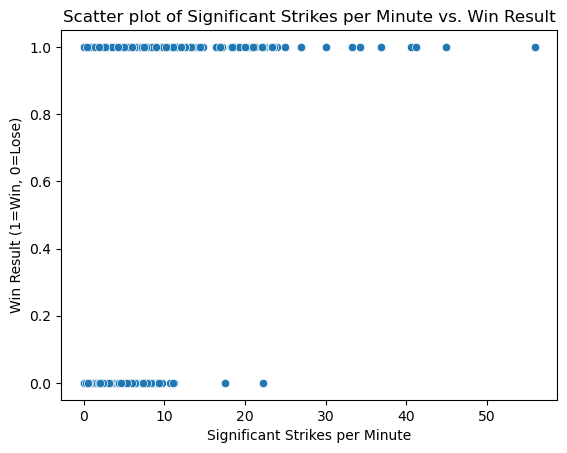

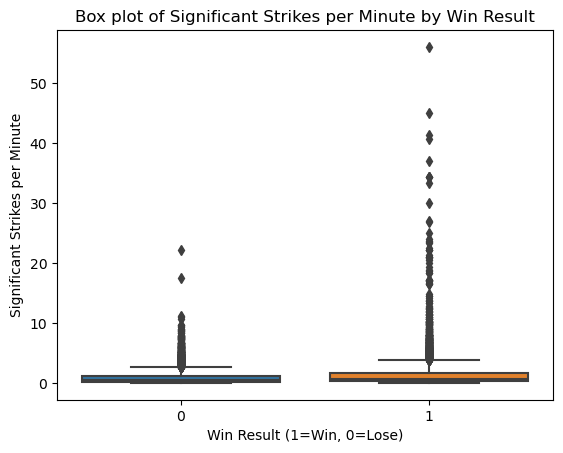

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Ensure that you are using the correct DataFrame name. I will use df_basic_relevant throughout.
print("Correlation coefficient:", df_basic_relevant['sig_strikes_per_minute'].corr(df_basic_relevant['result']))

# Logistic Regression
model = LogisticRegression()
model.fit(df_basic_relevant[['sig_strikes_per_minute']], df_basic_relevant['result'])

# Predicting and Evaluating
predictions = model.predict(df_basic_relevant[['sig_strikes_per_minute']])
print(classification_report(df_basic_relevant['result'], predictions))
print("Confusion Matrix:\n", confusion_matrix(df_basic_relevant['result'], predictions))

# Visualization with Scatter and Box Plot
sns.scatterplot(data=df_basic_relevant, x='sig_strikes_per_minute', y='result')
plt.title('Scatter plot of Significant Strikes per Minute vs. Win Result')
plt.xlabel('Significant Strikes per Minute')
plt.ylabel('Win Result (1=Win, 0=Lose)')
plt.show()

sns.boxplot(x='result', y='sig_strikes_per_minute', data=df_basic_relevant)
plt.title('Box plot of Significant Strikes per Minute by Win Result')
plt.xlabel('Win Result (1=Win, 0=Lose)')
plt.ylabel('Significant Strikes per Minute')
plt.show()
